In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, struct,col

In [2]:
spark=SparkSession.builder.appName("Project").getOrCreate()

In [3]:
# Đọc dữ liệu từ csv
df=spark.read.csv('hotel_bookings.csv', sep =',', header = True,inferSchema=True)

# Data Semantics

In [4]:
# Số lượng thuộc tính
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [99]:
#Số lượng dữ liệu
len(df.columns)

32

# Data Cleaning

In [5]:
#Kiểm tra data có duplicates không.
df.distinct().count()

87396

In [4]:
#Kết quả cho thấy chỉ còn 85598 so với 119390. Data đã bị duplicated. Tiến hành xóa
df=df.drop_duplicates()
df.count()

87396

In [8]:
df.show(5)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+------+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|   adr|required_car_parking_spaces|to

In [7]:
from pyspark.sql.types import *
#Thuộc tính children nên chuyển về kiểu dữ liệu int
df = df.withColumn('children',df['children'].cast(IntegerType()))
#Thuộc tính reservation_status_date nên chuyển về kiểu dữ liệu date
df = df.withColumn('reservation_status_date',df['reservation_status_date'].cast(DateType()))
df = df.where(df.children.isNotNull())
df = df.withColumn('arrival_date_month',df['arrival_date_month'].cast(IntegerType()))


In [9]:
quantity=df.count()

In [15]:
#Kiểm có Null ở các cột
Col_Null={col:(df.filter(upper(df[col]).contains('NULL')).count())/quantity for col in df.columns}

In [17]:
column=df.columns

In [22]:
Col_Null

{'hotel': 0.0,
 'is_canceled': 0.0,
 'lead_time': 0.0,
 'arrival_date_year': 0.0,
 'arrival_date_month': 0.0,
 'arrival_date_week_number': 0.0,
 'arrival_date_day_of_month': 0.0,
 'stays_in_weekend_nights': 0.0,
 'stays_in_week_nights': 0.0,
 'adults': 0.0,
 'children': 0.0,
 'babies': 0.0,
 'meal': 0.0,
 'country': 0.005171861412421621,
 'market_segment': 0.0,
 'distribution_channel': 0.0,
 'is_repeated_guest': 0.0,
 'previous_cancellations': 0.0,
 'previous_bookings_not_canceled': 0.0,
 'reserved_room_type': 0.0,
 'assigned_room_type': 0.0,
 'booking_changes': 0.0,
 'deposit_type': 0.0,
 'agent': 0.13951439425145315,
 'company': 0.9398256213098998,
 'days_in_waiting_list': 0.0,
 'customer_type': 0.0,
 'adr': 0.0,
 'required_car_parking_spaces': 0.0,
 'total_of_special_requests': 0.0,
 'reservation_status': 0.0,
 'reservation_status_date': 0.0}

In [23]:
for i in column:
    if Col_Null[i] >0.1:
        df = df.drop(i)

In [24]:
df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [9]:
from pyspark.sql.functions import regexp_replace

In [10]:
#Ta thấy cột company và cột agent chứa rất nhiều giá trị NULL tuy nhiên việc đặt phòng qua công ty hoặc đại lý nào ít ảnh 
#hưởng đến quyết định hủy phòng của khách hàng nên ta bỏ luôn hai cột này
drop_column = ['company','agent']
for col in drop_column:
    df = df.drop(col)

In [11]:
#Cột country chứa 452 giá trị NULL có thể chuyển nó thành 'Unknown' , tuy nhiên ta nên bỏ luôn cột này vì trên thực tế yếu tố địa lý cũng rất 
#ít ảnh hưởng đến quyết định hủy phòng.
df=df.drop('country')

In [12]:
#Kiểm tra lại các giá tị NULL
Col_Null={col:df.filter(upper(df[col]).contains('NULL')).count() for col in df.columns}
Col_Null

{'hotel': 0,
 'is_canceled': 0,
 'lead_time': 0,
 'arrival_date_year': 0,
 'arrival_date_month': 0,
 'arrival_date_week_number': 0,
 'arrival_date_day_of_month': 0,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 0,
 'adults': 0,
 'children': 0,
 'babies': 0,
 'meal': 0,
 'market_segment': 0,
 'distribution_channel': 0,
 'is_repeated_guest': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'reserved_room_type': 0,
 'assigned_room_type': 0,
 'booking_changes': 0,
 'deposit_type': 0,
 'days_in_waiting_list': 0,
 'customer_type': 0,
 'adr': 0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0,
 'reservation_status': 0,
 'reservation_status_date': 0}

Sửa đổi kiểu dữ liệu

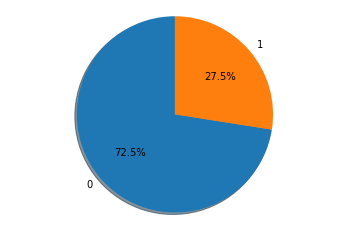

In [13]:
# Tỉ lệ hủy phòng so với giữ nguyên! 
total_count=df.count()
# 1 là hủy, 0 là không!
label=['0','1']
percentages=map(lambda label: df.where('is_canceled ="{}"'.format(label)).count()/total_count,label)
percentages=list(percentages)
fig,ax=plt.subplots()
ax.pie(percentages,labels=label,autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis('equal')
plt.show()
#Con số hủy phòng khá cao. Chiếm đến 27,5%

<AxesSubplot:xlabel='is_canceled', ylabel='days_in_waiting_list'>

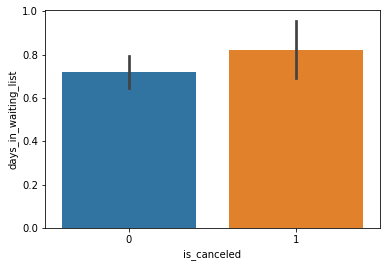

In [25]:
#Biểu diễu ngày đợi của khách hàng
import seaborn as sns
sns.barplot(x = "is_canceled", y = "days_in_waiting_list",data = df.toPandas())

<AxesSubplot:title={'center':'Count of booking changes'}, xlabel='previous_cancellations', ylabel='count'>

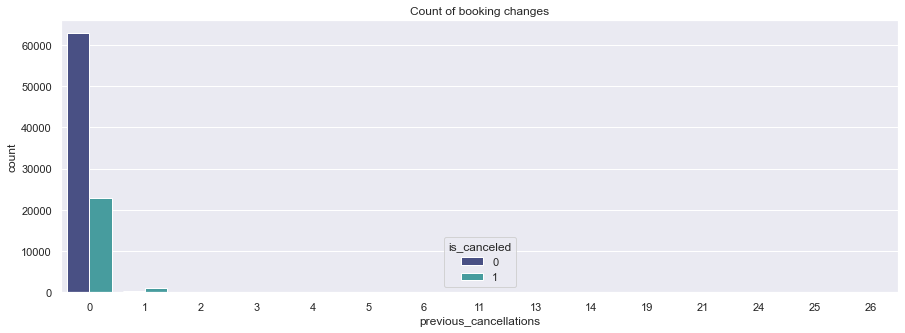

In [15]:
import calendar
import seaborn as sns
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of previous cancellations")
sns.countplot(x='previous_cancellations', hue='is_canceled', palette="mako",data = df.toPandas())

In [ ]:
df

<AxesSubplot:title={'center':'Count of require '}, xlabel='customer_type', ylabel='count'>

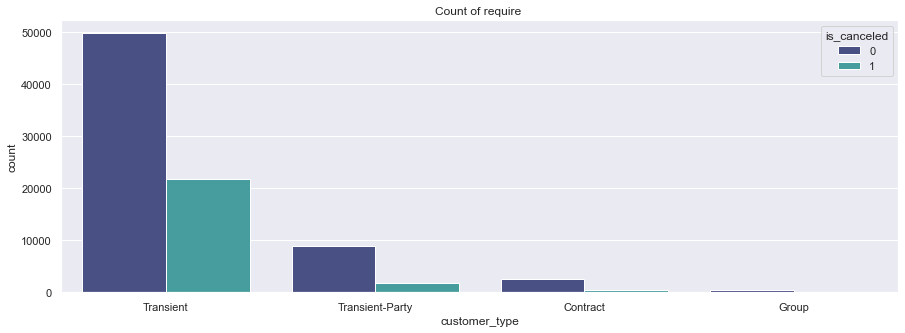

In [30]:
import calendar
import seaborn as sns
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of require ")
sns.countplot(x='customer_type', hue='is_canceled', palette="mako",data = df.toPandas())

Sau khi làm sạch dữ liệu , chúng ta còn lại 87230 row x 32 column so với ban đầu là 119390 x 32 

# FEATURE SELECTION

Đối với bài toán này ta cần lựa chọn các feature có đóng góp ý nghĩa đối với việc hủy phòng và loại bỏ các feature còn lại để
giảm bớt độ phức tạp cho mô hình

- Hotel: Phân tích biểu đồ tỉ lệ phần trăm hủy bỏ đối mỗi tháng của 2 loại khách sạn sẽ thấy sự khác nhau khi loại resort sẽ bị hủy nhiều hơn vào mùa hè chứng tỏ hai thuộc tính hotel và arrival_date_month cùng tác động đến tỉ lệ canceled (chưa vẽ được biểu đồ)
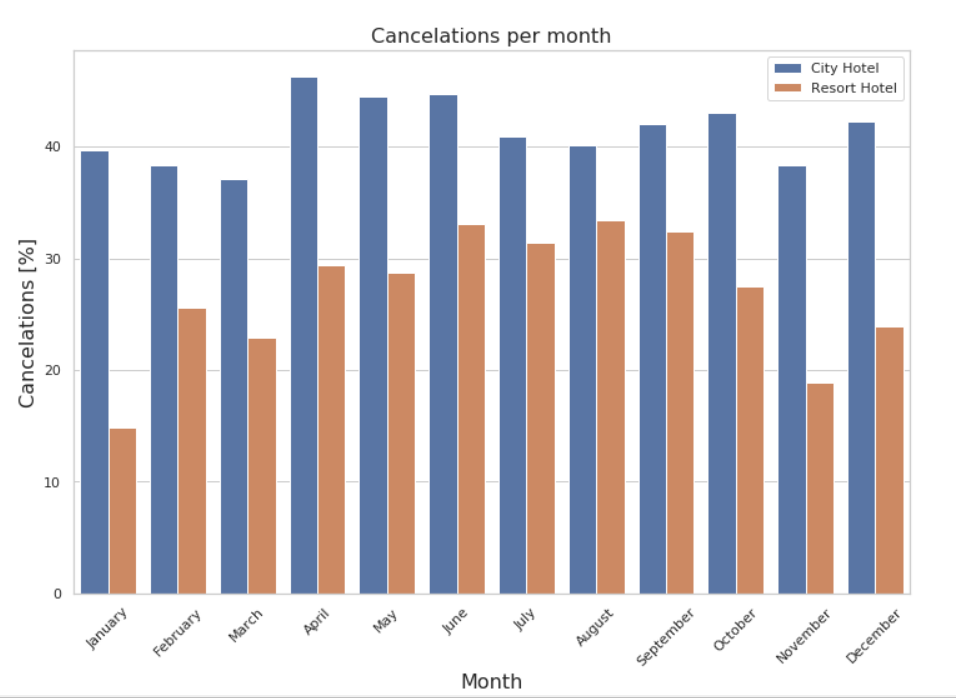



- lead_time: ta có thể nhận thấy rằng trong thực tế những người đặt khách sạn càng gần thời gian đến sẽ có xu hướng khó hủy hơn so với những người đặt từ lâu. Điều này là hợp lí nên lead_time cũng được chọn
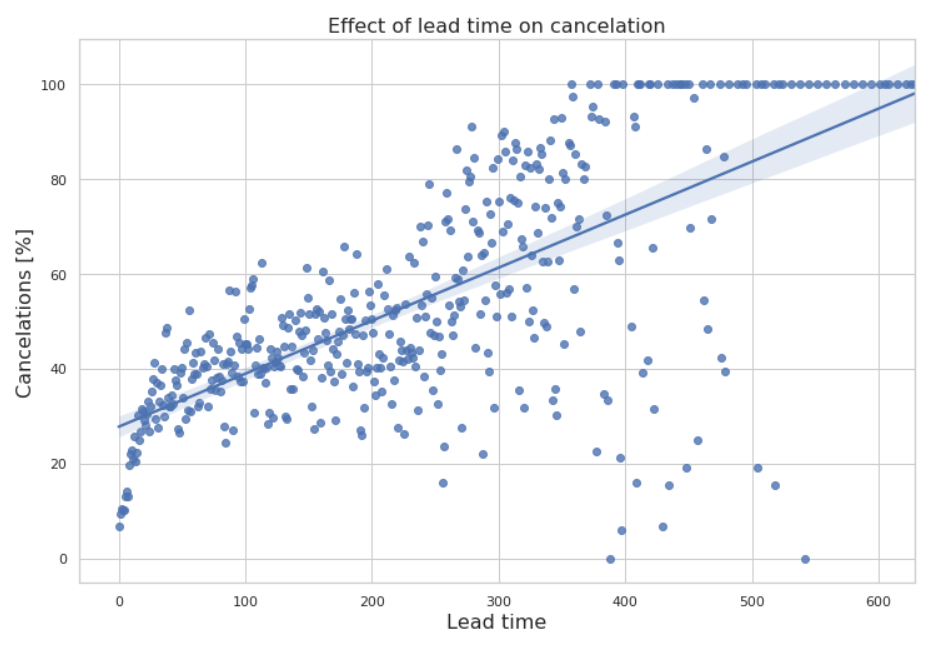

- arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month: Các yếu tố về thời gian
    + arrival_date_month: như đã phân tích ở thuộc tính hotel (chọn)
    + arrival_date_year: mỗi năm lại có những biến cố thay đổi khác nhau nên ta không sử dụng thuộc tính này (loại)
    + arrival_date_week_number: thuộc tính có thể xem là tương đương với arrival_date_month nên ta có thể loại (loại)
    + arrival_date_day_of_month: với thuộc tính này ta cũng không thể quyết định được liệu khách hàng có hủy phòng hay không.(loại)
- stays_in_weekend_nights: những đơn đặt phòng càng rơi nhiều vào những ngày cuối tuần thì xác suất hủy phòng có thể thấp hơn vì cuối tuần chúng ta thường đi chơi, thư giãn, ít bận bịu công việc => chọn
- stays_in_week_nights: những đơn đặt phòng càng rơi nhiều vào những làm việc trong tuần thì xác suất hủy phòng có thể tăng lên => chọn
- adults, children, babies: Ta có thể thấy rằng trong thực tế những nhóm người càng có nhiều người và có nhiều children và babies hơn thì xác suất hủy phòng cao hơn vì dễ xảy ra biến cố (bận việc, đau ốm,...) nên ta có thể chọn cả 3 thuộc tính này
- meal: việc đặt trước ăn,loại thức ăn cũng phần nào đó thể hiện tầm quan trọng của đơn đặt phòng => tính đảm bảo của việc không hủy phòng cho nên ta giữ lại thuộc tính này
- market_segment, distribution_channel: đây là các thuộc tính về hình thức đặt phòng. Mỗi hình thức đặt phòng cũng sẽ phản ánh một tỉ lệ hủy phòng khác nhau. Ví dụ: đặt phòng dạng doanh nghiệp hoặc tour du lịch sẽ khó bị hủy hơn so với đặt phòng cá nhân. vì nó thường có các điều khoản hợp đồng. => chọn
- is_repeated_guest: việc một người có phải là khách hàng cũ không ảnh hưởng đến việc hủy phòng. Loại.
- previous_cancellation: thuộc tính này có thể giúp xác định khách hàng có phải spam hay không nên ta có thể chọn.
- previous_bookings_not_canceled: thuộc tính này giúp xác định uy tín của khách hàng, ta có thể chọn.
- reserved_room_type, assigned_room_type: Đat :hai thuộc tính này nói về mong muốn loại phòng của khách hàng và loại phòng được chỉ định, nó cũng phần nào phản ánh được mức độ hài lòng của khách hàng về phòng đã đặt của mình, ta chọn luôn cả 2 thuộc tính
- assigned_room_type  Dũng:Tương tự như reserved_room_type =>>> Loại
- booking_changes: Đạt những khách hàng sửa đổi càng nhiều có xu hướng quan tâm đến việc đặt phòng của mình nhiều hơn, do vậy đơn đặt phòng sẽ khó bị hủy hơn => chọn
- deposit_type: loại thanh toán không thể hiện được điều gì . Thể hiện ở visualize => loại!!!!!!!!! 
- days_in_waiting_list: Đạt: thuộc tính này có thể phản ánh được chất lượng phục vụ khách hàng => chọn
      Dũng: Thuộc tính thay đổi theo thời gian có nhiều trường hợp.Khiến model không tổng quát được.Dựa vô visual tăng không đáng kể=>>Loại
- customer_type: phản ánh được tính ràng buộc giữa khách hàng và khách sạn đối với việc hủy phòng => chọn
- adr: giá tiền thường đã được khách hàng xem xét kĩ khi quyết định đặt phòng nên thuộc tính này ít ảnh hưởng đến việc hủy phòng => loại
- required_car_parking_spaces:  Đat:nhu cầu về đậu xe ít phản ánh => loại
                             Dũng:Biểu đồ visua cho thấy sự phản ảnh có liên quan đến chỗ đậu xe.=>> Chọn
- total_of_special_requests: càng nhiều yêu cầu đặc biệt thì tính chất càng quan trọng => chọn
- reservation_status: Đat: nếu trạng thái cuối cùng là canceled thì chắc chắn sẽ bị canceled => chọn
                      Dũng: Đây sẽ là output mà model cố gắng dự đoán.Sẽ gây ra nhiễu ->>> Loại
- reservation_status_date: ngày trạng thái cuối cùng không quan trọng => loại

Tổng kết: 
  - Các thuộc tính được chọn: hotel, leadtime, arrival_date_month, stays_in_weekend_nights, stays_in_week_nights,  adults, children, babie, meal, market_segment, distribution_channel, previous_cancellation, previous_bookings_not_canceled, reserved_room_type,assigned_room_type, booking_changes, days_in_waiting_list, customer_type,  total_of_special_requests,  reservation_status ( 20 thuộc tính)
  - Các thuộc tính bị loại:  arrival_date_year, arrival_date_week_number, arrival_date_day_of_month, is_repeated_guest, deposit_type, adr, required_car_parking_spaces, reservation_status_date,reservation_status (9 thuộc tính)

In [14]:
#Drop columns được cho là không quan trọng
drop_columns = ['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','is_repeated_guest','deposit_type','adr','reservation_status_date','reservation_status','days_in_waiting_list','booking_changes','assigned_room_type']
selected_df = df.select('*')
for col in drop_columns:
    selected_df = selected_df.drop(col)

In [15]:
Col_Null={col:selected_df.filter(upper(selected_df[col]).contains('NULL') | selected_df[col].contains('NA')).count() for col in selected_df.columns}
Col_Null

{'hotel': 0,
 'is_canceled': 0,
 'lead_time': 0,
 'arrival_date_month': 0,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 0,
 'adults': 0,
 'children': 0,
 'babies': 0,
 'meal': 0,
 'market_segment': 0,
 'distribution_channel': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'reserved_room_type': 0,
 'customer_type': 0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0}

In [16]:
#Xác định các giá trị có tần xuất xuất hiện nhiều nhất
selected_df.groupBy('children').count().show()
selected_df=selected_df.withColumn('children', regexp_replace('children', 'NA', '0'))


+--------+-----+
|children|count|
+--------+-----+
|       1| 4695|
|       3|   75|
|      10|    1|
|       2| 3593|
|       0|79028|
+--------+-----+



In [17]:
#ở cột market_segment có một số giá trị là "Undefined"  được chuyển đổi thành "Online TA"
selected_df=selected_df.withColumn('market_segment', regexp_replace('market_segment', 'Undefined', 'Online TA'))
selected_df.groupBy('market_segment').count().show()

+--------------+-----+
|market_segment|count|
+--------------+-----+
| Offline TA/TO|13889|
| Complementary|  702|
|      Aviation|  227|
|        Direct|11803|
|     Corporate| 4212|
|     Online TA|51617|
|        Groups| 4942|
+--------------+-----+



In [18]:
#ở cột distribution_chanel có một số giá trị là "Undefined"  được chuyển đổi thành "TA/TO"
selected_df=selected_df.withColumn('distribution_channel', regexp_replace('distribution_channel', 'Undefined', 'TA/TO'))
selected_df.groupBy('distribution_channel').count().show()


+--------------------+-----+
|distribution_channel|count|
+--------------------+-----+
|               TA/TO|69142|
|              Direct|12988|
|                 GDS|  181|
|           Corporate| 5081|
+--------------------+-----+



In [54]:
selected_df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [ ]:
# encoding sau khi đã biến đổi các label sang dạng số trong phần trước. Lý do khá đơn gián. Xem xét các thể loại trò chơi điện tử, nếu chúng ta trực tiếp cung cấp các giá trị GenreLabel như một đặc trưng (feature) trong mô hình học máy thì thuật toán sẽ hiểu rằng đây là một đặc trưng dạng số liên tục và giá trị 10 (Sports) sẽ lớn hơn giá trị 6 (Racing), nhưng điều đó là vô nghĩa vì thể loại Sports chắc chắn không có ý nghĩa lớn hơn hoặc nhỏ hơn thể loại Racing, 
#đây thực chất chỉ là các giá trị hoặc danh mục khác nhau, không thể so sánh trực tiếp. Do đó, chúng ta cần một bước bổ sung là encoding trong đó các đặc trưng giả được tạo ra cho mỗi giá trị hoặc danh mục của mỗi đặc trưng.

# DATA ENGINEER

In [19]:
# chuyển đổi biến categorical thành các biến giả / chỉ số.
meal=selected_df.select('meal').distinct().rdd.flatMap(lambda x:x).collect()
market_segment=selected_df.select('market_segment').distinct().rdd.flatMap(lambda x:x).collect()
distribution_channel=selected_df.select('distribution_channel').distinct().rdd.flatMap(lambda x:x).collect()
customer_type=selected_df.select('customer_type').distinct().rdd.flatMap(lambda x:x).collect()
hotel=selected_df.select('hotel').distinct().rdd.flatMap(lambda x:x).collect()


In [20]:
#Convert one hot encoding
import pyspark.sql.functions as F
convert_meal = [F.when(F.col("meal") == x, 1).otherwise(0).alias("meal_" + x) for x in meal]
convert_market= [F.when(F.col("market_segment") == x, 1).otherwise(0).alias("market_segment_" + x) \
                 for x in market_segment]
convert_channel = [F.when(F.col("distribution_channel") == x, 1).otherwise(0).alias("distribution_channel_" + x) \
                   for x in distribution_channel]
convert_custype = [F.when(F.col("customer_type") == x, 1).otherwise(0).alias("customer_type_" + x) \
                   for x in customer_type]
convert_hotel = [F.when(F.col("hotel") == x, 1).otherwise(0).alias("hotel_" + x) for x in hotel]

In [21]:
data = selected_df.select(
 'is_canceled',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests', *convert_meal+convert_market+convert_channel+convert_roomtype+convert_custype+convert_hotel)

In [25]:
data.count()

87392

In [ ]:
# Chuyển đổi các month thành số
month_dict={'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7, 'August':8, 'September':9, 'October':10
            , 'November':11, 'December':12 }
#Convert Month qua số để chạy model
user_func =  udf (lambda x: month_dict[x])
data=data.withColumn('arrival_date_month',user_func(data['arrival_date_month']))
#df_replace=df.replace(month_dict,subset=['arrival_date_month'])

In [73]:
numeric_features = ['lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [74]:
test1=data.select(numeric_features)

In [75]:
numeric_summary=data.select(numeric_features).describe().toPandas().transpose()

In [76]:
numeric_summary

,0,1,2,3,4
summary,count,mean,stddev,min,max
lead_time,87230,79.97101914478964,86.05868316840484,0,737
arrival_date_month,87230,6.474905422446406,3.0964771915566023,1,9
stays_in_weekend_nights,87230,1.0046085062478505,1.0274084252725395,0,19
stays_in_week_nights,87230,2.623925255072796,2.039830452717406,0,50
adults,87230,1.8793648973976842,0.6217239565603969,0,55
children,87230,0.13889716840536512,0.4562648107166671,0,3
babies,87230,0.010844892812105928,0.11370359244376349,0,10
previous_cancellations,87230,0.030402384500745158,0.36934446068533255,0,26
previous_bookings_not_canceled,87230,0.184053651266766,1.7330334804975553,0,72


In [77]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.broadcast(numeric_summary)

In [82]:
rdd1 = test1.rdd.map(list).map(lambda x: list(float(float(x[i])-float(numeric_summary[3][i+1]))
                                              /float(float(numeric_summary[4][i+1])-float(numeric_summary[3][i+1])) 
                                                               for i in range(len(x))))

In [83]:
data1=rdd1.toDF()

In [85]:
cols=test1.columns

In [86]:
for i in range(len(test1.columns)):
    data1=data1.withColumnRenamed(data1.columns[i],cols[i])

In [95]:
data1.show()

+--------------------+------------------+-----------------------+--------------------+-------------------+--------+------+----------------------+------------------------------+---------------------------+-------------------------+
|           lead_time|arrival_date_month|stays_in_weekend_nights|stays_in_week_nights|             adults|children|babies|previous_cancellations|previous_bookings_not_canceled|required_car_parking_spaces|total_of_special_requests|
+--------------------+------------------+-----------------------+--------------------+-------------------+--------+------+----------------------+------------------------------+---------------------------+-------------------------+
|  0.4396200814111262|              0.75|    0.21052631578947367|                 0.2|0.03636363636363636|     0.0|   0.0|                   0.0|                           0.0|                        0.0|                      0.0|
|  0.0407055630936228|              0.75|                    0.0|           

In [91]:
numeric_date=data1.select(numeric_features).toPandas()


NameError: name 'scatter_matrix' is not defined

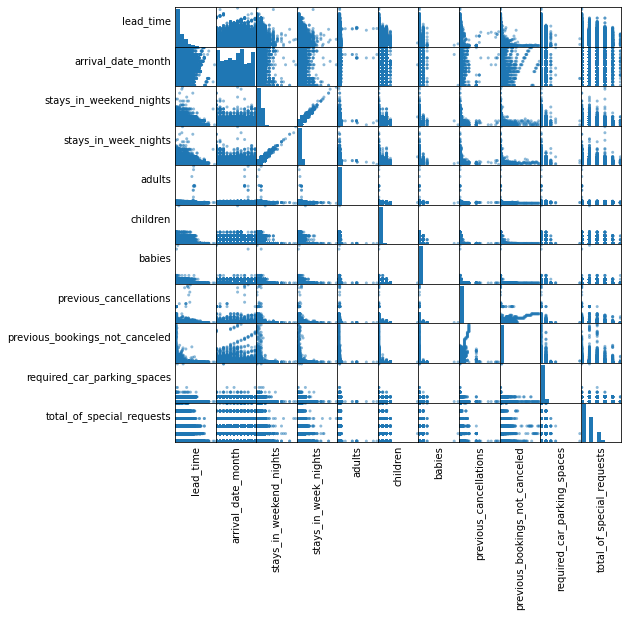

In [94]:
from pandas.plotting import scatter_matrix
axs=scatter_matrix(numeric_date,figsize=(8,8))
n=len(numeric_features)
for i in range(n):
    v=axs[i,0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h=axs[n-1,i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [87]:
ori_data = data.select('is_canceled',
 'meal_SC',
 'meal_FB',
 'meal_BB',
 'meal_HB',
 'market_segment_Offline TA/TO',
 'market_segment_Complementary',
 'market_segment_Aviation',
 'market_segment_Direct',
 'market_segment_Corporate',
 'market_segment_Online TA',
 'market_segment_Groups',
 'distribution_channel_TA/TO',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_Corporate',
 'reserved_room_type_F',
 'reserved_room_type_E',
 'reserved_room_type_B',
 'reserved_room_type_L',
 'reserved_room_type_D',
 'reserved_room_type_C',
 'reserved_room_type_A',
 'reserved_room_type_G',
 'reserved_room_type_H',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'customer_type_Group',
 'customer_type_Contract',
 'hotel_City Hotel',
 'hotel_Resort Hotel')

In [88]:
from pyspark.sql.functions import monotonically_increasing_id

DF1 = ori_data.withColumn("row_id", monotonically_increasing_id())
DF2 = data1.withColumn("row_id", monotonically_increasing_id())
result_df = DF1.join(DF2, ("row_id")).drop("row_id")

In [96]:
result_df.printSchema()

root
 |-- is_canceled: integer (nullable = true)
 |-- meal_SC: integer (nullable = false)
 |-- meal_FB: integer (nullable = false)
 |-- meal_BB: integer (nullable = false)
 |-- meal_HB: integer (nullable = false)
 |-- market_segment_Offline TA/TO: integer (nullable = false)
 |-- market_segment_Complementary: integer (nullable = false)
 |-- market_segment_Aviation: integer (nullable = false)
 |-- market_segment_Direct: integer (nullable = false)
 |-- market_segment_Corporate: integer (nullable = false)
 |-- market_segment_Online TA: integer (nullable = false)
 |-- market_segment_Groups: integer (nullable = false)
 |-- distribution_channel_TA/TO: integer (nullable = false)
 |-- distribution_channel_Direct: integer (nullable = false)
 |-- distribution_channel_GDS: integer (nullable = false)
 |-- distribution_channel_Corporate: integer (nullable = false)
 |-- reserved_room_type_F: integer (nullable = false)
 |-- reserved_room_type_E: integer (nullable = false)
 |-- reserved_room_type_B: in

# Thuật toán Logistics regression

In [208]:
training, test = result_df.randomSplit([0.75, 0.25])

In [32]:
test.count()

21628

In [33]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [34]:
def gradient_descent(X, theta, alpha, num_inters):
    m = X.count()    
    for i in range(num_inters):
        delta = X.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]), theta))-p[1])).reduce(lambda x, y: x+y)
        theta -= delta*alpha/m
    return theta

In [35]:
def predict (X,theta):
    prob = sigmoid(np.dot(X, theta))
    return [1 if x >= 0.5 else 0 for x in prob]

In [66]:
def score (X,theta):
    rdd_kq = X.map(lambda x: (x[0],sigmoid(np.dot(np.array(x[1:len(x)]),theta))))
    rdd_kq = rdd_kq.map(lambda x: (x[0],1 if x[1]>=0.5 else 0))
    rdd_acc = rdd_kq.map(lambda x: (1 if x[0] == x[1] else 0))
    
    acc = rdd_acc.reduce(lambda a,b: a+b)/rdd_acc.count()
    tp = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fp = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fn = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    tn = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    print (' True Positive : {0}'.format(tp))
    print (' False Positive : {0}'.format(fp))
    print (' False Negative : {0}'.format(fn))
    print (' True Negative : {0}'.format(tn))
    lo_cm = np.array([[tp,fn],[fp,tn]])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return acc, lo_cm, precision, recall, f1_score

In [54]:
import time
import pandas as pd
import numpy as np
theta = np.zeros(len(training.columns)-1)
start_time = time.time()
result= training.rdd.map(list).map(lambda p: (p[1:len(p)],p[0]))
theta = gradient_descent(result,theta,0.1,100)
end_time = time.time()
print ('Total run-time of logistics regression: %f h' % ((end_time - start_time) /3600 ))

Total run-time of logistics regression: 0.000000 h


In [69]:
acc,lo_cm, precision, recall, f1_score = score(test.rdd,theta)
print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))

 True Positive : 10573
 False Positive : 4624
 False Negative : 5030
 True Negative : 1400
Logistics Regression Accuracy Score: 0.5536135386322653
Precision: 0.6957294202803185
Recall: 0.6776260975453439
F1-score: 0.6865584415584415


In [56]:
test = test.withColumn('arrival_date_month',test['arrival_date_month'].cast(IntegerType()))

In [64]:
test=test.where(test.children.isNotNull())

In [ ]:
rdd1 = numeric_df.rdd.map(list).map(lambda x: list(float(x[i]-numeric_summary[3][i+1])/float(numeric_summary[4][i+1]-numeric_summary[3][i+1]) for i in range(len(x))))